In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation



### Load Data 

In [124]:
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [47]:
X = df.iloc[:, [0, 1, 2, 3]].values
X=X.astype(float)
X=np.array(X)

In [85]:
def power_iteration(matrix, num_iterations, tolerance):
    # Initialize a random vector as an initial guess for the eigenvector
    n = matrix.shape[0]
    eigenvector = np.random.rand(n)
    for _ in range(num_iterations):
        # Perform matrix-vector multiplication
        matrix_times_vector = np.dot(matrix, eigenvector)

        # Compute the eigenvalue as the Rayleigh quotient
        eigenvalue = np.dot(eigenvector, matrix_times_vector)

        # Normalize the eigenvector
        eigenvector = matrix_times_vector / np.linalg.norm(matrix_times_vector)

        # Check for convergence
        if np.linalg.norm(matrix_times_vector - eigenvalue * eigenvector) < tolerance:
            break

    return eigenvalue, eigenvector

def eigen(matrix, num_iterations=10000, tolerance=1e-10):
    # Initialize arrays to store eigenvalues and eigenvectors
    eigenvalues = []
    eigenvectors = []
    matrix = np.array(matrix).astype(float)

    # Perform power iteration for each eigenvalue
    for _ in range(matrix.shape[0]):
        eigenvalue, eigenvector = power_iteration(matrix, num_iterations, tolerance)
        eigenvalues.append(eigenvalue)
        eigenvectors.append(eigenvector)

        # Deflate the matrix by removing the contribution of the found eigenvalue
        matrix -= eigenvalue * np.outer(eigenvector, eigenvector)

    return np.array(eigenvalues), np.array(eigenvectors)

### PCA IMPLEMENTATION FROM SCRATCH

In [89]:
def _PCA(X, n_components=2):
    if n_components > X.shape[1]:
        raise ValueError("n_components cannot be greater than the number of features")

    # 1. Standardize data by subtracting mean and dividing by standard deviation
    mean_values = X.mean(axis=0)
    std_values = X.std(axis=0)
    X_standardized = (X - mean_values) / std_values

    # 2. Covariance matrix From Scratch
    cov = np.dot(X_standardized.T, X_standardized) / (X_standardized.shape[0])  # (n_features, n_features)

    # 3. Eigen decomposition
    eigen_values, eigen_vectors = eigen(cov)

    # 4. Sort eigen values in descending order
    idx = eigen_values.argsort()[::-1]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]

    # 5. Select top n_components
    eigen_vectors = eigen_vectors[:, :n_components]

    # 6. Project original data
    X_pca = np.dot(X_standardized, eigen_vectors)

    # 7. Inverse transform to get reconstructed data
    X_reconstructed = np.dot(X_pca, eigen_vectors.T) * std_values + mean_values

    return eigen_values, eigen_vectors, X_pca, X_reconstructed


In [90]:
def loss (X, X_reconstructed):
    return (np.sum(abs(X - X_reconstructed))/X.shape[0])

In [125]:
lossList=[]
for _ in range(1,X.shape[1]+1):
    eigen_values, eigen_vectors, X_pca, X_reconstructed = _PCA(X, n_components=_)
    lossList.append(loss(X,X_reconstructed).round(3))
    print("Loss for ",_, "components: ",loss(X,X_reconstructed).round(3))

Loss for  1 components:  3.105
Loss for  2 components:  2.378
Loss for  3 components:  2.861
Loss for  4 components:  0.0


In [65]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)
# X_reconstructed = pca.inverse_transform(X_pca)

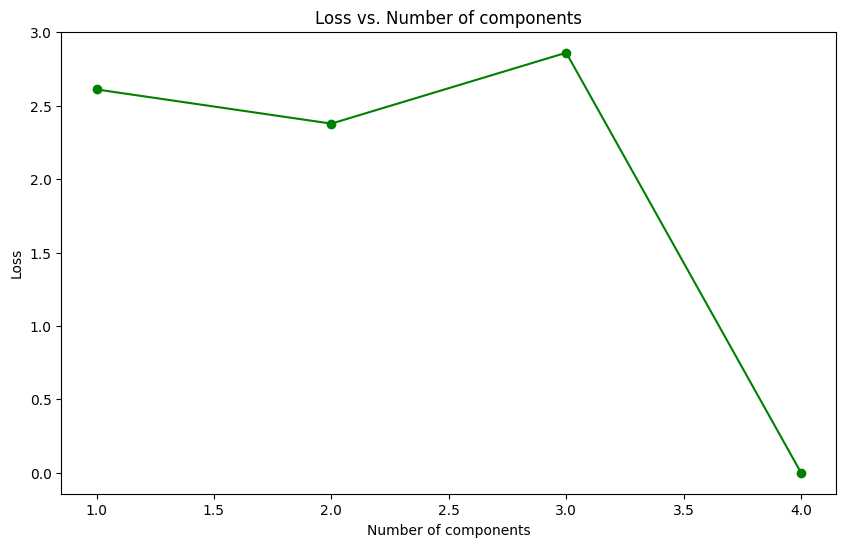

In [92]:
# Plotting the Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, X.shape[1]+1), lossList, marker='o', color='green')
plt.xlabel('Number of components')
plt.ylabel('Loss')
plt.title('Loss vs. Number of components')
plt.show()

In [93]:
eigen_values, eigen_vectors, X_pca, X_reconstructed = _PCA(X, n_components=2)

C:\Users\ziadw\AppData\Local\Temp\ipykernel_19336\3201026772.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c="green", cmap='viridis')


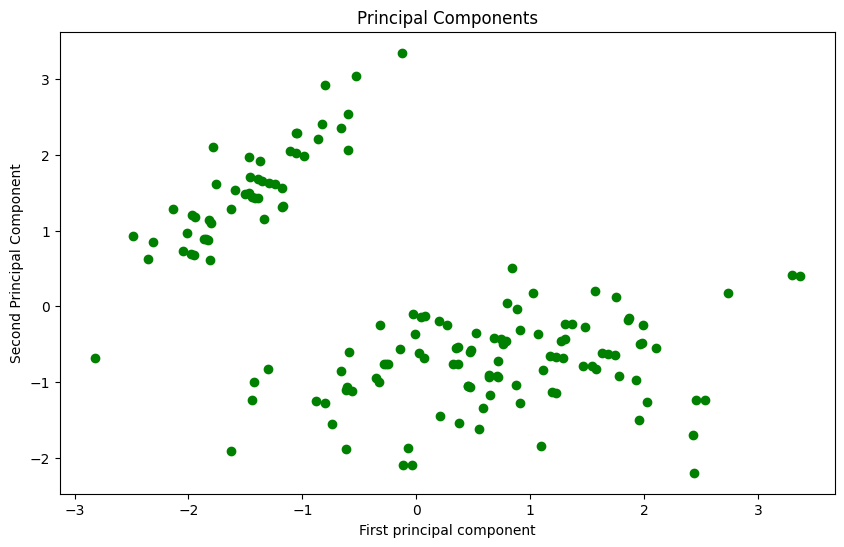

In [94]:
# Plotting the X_pca 
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c="green", cmap='viridis')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title('Principal Components')
plt.show()

In [95]:
# utility values
data=X_pca
g=2
n=len(data)
c=3
p=len(data[0])
max_iter=100

In [96]:
def euclidean_distance(point1,point2):
    dis=0
    for i in range(len(point1)):
        dis+=(point1[i]-point2[i])**2
    return dis**0.5

### Fuzzy C Means Clustering Algorithm Implementation

In [97]:
import random
import math
def initialize_membership_matrix(n,c):
    member_mat=list()
    for i in range(n):
        random_list=[random.random() for x in range(c)]
        summation=sum(random_list)
        for i in range(len(random_list)):
            random_list[i]=random_list[i]/summation
        member_mat.append(random_list)
    return member_mat

def update_centroid(member_mat):
    centroids={}
    for j in range(c):
        temp=[]
        for k in range(p):
            
            add=0
            for i in range(n):
                add+=member_mat[i][j]**g
            x=0
            for i in range(n):
                x+=(member_mat[i][j]**g)*(data[i][k])
            val=x/add
            temp.append(val)
        centroids[j]=temp
    return centroids


def update_membership_matrix(member_mat,centroids):
    ratio=float(2/(g-1))

    for i in range(n):
        distances=list()
        for j in range(c):
            distances.append(euclidean_distance(data[i],centroids[j]))
        for j in range(c):
            den = sum([math.pow(float(distances[j]/distances[q]), ratio) for q in range(c)])
            member_mat[i][j] = float(1/den) 
           
            
    return member_mat
                        
    
def find_cluster(member_mat):
    clusters=list()
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(member_mat[i]))
        clusters.append(idx)
    return clusters

def check(old_member_mat,member_mat):
    diff=0
    for i in range(n):
        for j in range(c):
            diff+=old_member_mat[i][j]-member_mat[i][j]
    if(diff<0.01):
        return True
    return False

def fuzzy_c_mean():
    
    member_mat=initialize_membership_matrix(n,c)
    for i in range(max_iter):
        centroids=update_centroid(member_mat)
        old_member_mat=member_mat
        member_mat=update_membership_matrix(member_mat,centroids)
        cluster=find_cluster(member_mat)
        if(check(old_member_mat,member_mat))<0.001:
            print(i)
            break
    
   
    
    return cluster,centroids


In [105]:
fuzyy_cluster,centroids=fuzzy_c_mean()

In [106]:
print(centroids)

{0: [-1.4542898807838096, 1.524457735746672], 1: [-0.0397029278042012, -0.8747882994047346], 2: [1.547777446125921, -0.5995494683732622]}


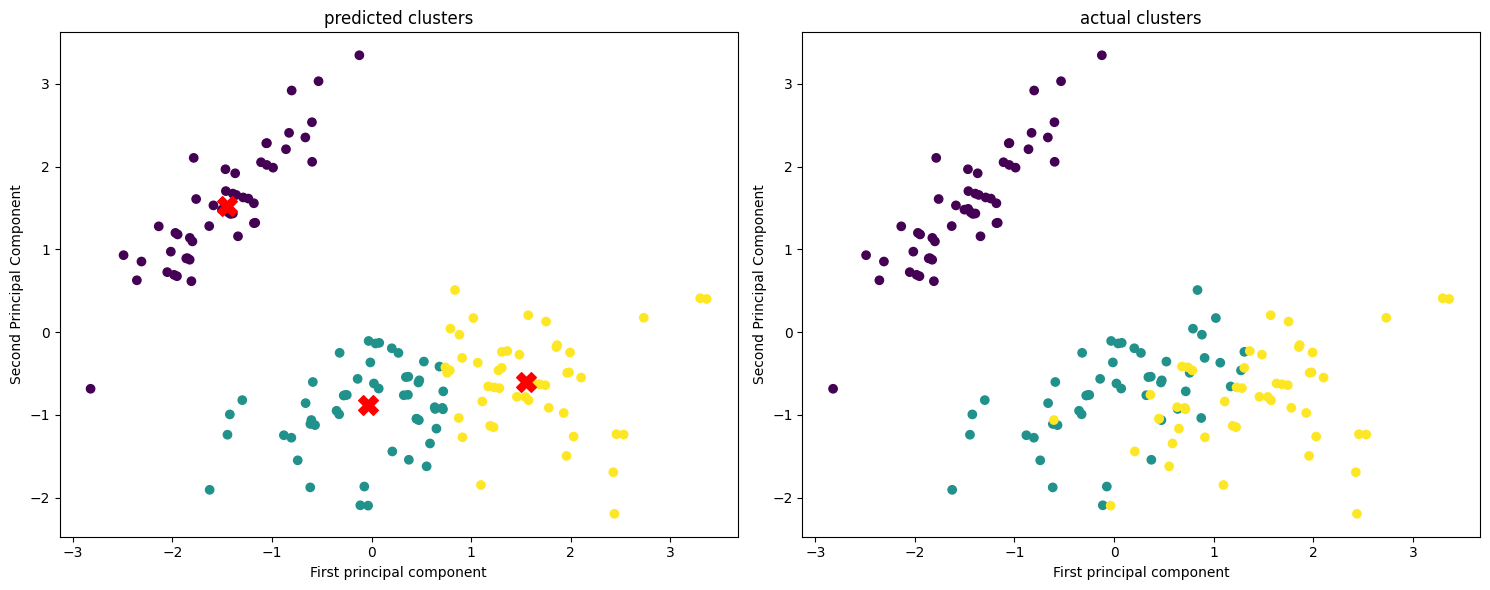

In [107]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=fuzyy_cluster, cmap='viridis')
plt.scatter(np.array(list(centroids.values()))[:,0], np.array(list(centroids.values()))[:,1], marker='X', s=200, c='red')

plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title('predicted clusters')

# Plotting the second subplot
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=iris.target, cmap='viridis')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title('actual clusters')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [108]:
# update the original data with the cluster number
df['cluster'] = fuzyy_cluster
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),cluster
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [109]:
target = iris.target
# compare the original target and the cluster number
num_correct = 0
misclassified = []
for i in range(n):
    if target[i] == df['cluster'][i]:
        num_correct += 1
    else:
        misclassified.append(i)
print("Accuracy: ", (num_correct/n)*100)

Accuracy:  84.0


In [110]:
misclassified

[50,
 51,
 52,
 56,
 65,
 70,
 75,
 76,
 77,
 85,
 86,
 101,
 106,
 113,
 114,
 119,
 121,
 123,
 126,
 133,
 134,
 138,
 142,
 146]

C:\Users\ziadw\AppData\Local\Temp\ipykernel_19336\3410061323.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[misclassified, 0], X_pca[misclassified, 1], c='red', cmap='viridis')


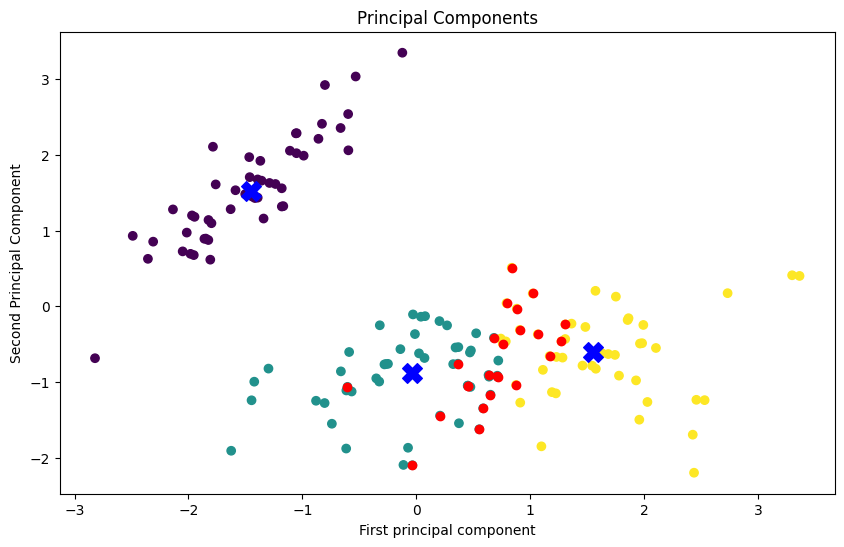

In [111]:
# Plotting the misclassified data
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=fuzyy_cluster, cmap='viridis')
# add centroids to the plot as X's
plt.scatter(X_pca[misclassified, 0], X_pca[misclassified, 1], c='red', cmap='viridis')
plt.scatter(np.array(list(centroids.values()))[:,0], np.array(list(centroids.values()))[:,1], marker='X', s=200, c='blue')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.title('Principal Components')
plt.show()
